# Regression task: the time interval between two consecutive visits for the same patient ~ ICD diagnosis code

## Prepare the dataset

In [1]:
""" 
Patient ID -> admission ID
"""

' \nPatient ID -> admission ID\n'

In [2]:
import sys
sys.path.append("/home/wanxinli/deep_patient/")

from datetime import datetime
from mimic_common import *
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import gaussian_process



/home/wanxinli/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
output_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/outputs/mimic")
print(f"Will save outputs to {output_dir}")
data_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/mimic_exp/mimiciii")
print(f"Will read data from {data_dir}")

Will save outputs to /home/wanxinli/deep_patient/outputs/mimic
Will read data from /home/wanxinli/deep_patient/mimic_exp/mimiciii


In [4]:
admission_file = os.path.join(data_dir, "ADMISSIONS.csv")
diagnosis_file = os.path.join(data_dir, "DIAGNOSES_ICD.csv")
patient_file = os.path.join(data_dir, "PATIENTS.csv")

In [5]:
pid_adms, pid_gender, adm_date, admid_codes, pid_visits = build_maps(admission_file, diagnosis_file, patient_file)


In [6]:
# print(pid_visits)

In [7]:
# construct codes (ICD codes for the first visits), and durations (time interval until the next visit)

codes = []
durations = []
genders = []
for pid, visits in pid_visits.items():
    for i, cur_visit in enumerate(visits):
        if i == len(visits)-1: # stop on the last element
            break 
        next_visit = visits[i+1]
        # print(next_visit)
        cur_codes = cur_visit[1]
        # print(codes)
        duration = (next_visit[0]-cur_visit[0]).total_seconds()
        codes.append(cur_codes)
        durations.append(duration)
        genders.append(pid_gender[pid])


cons_visits_df = pd.DataFrame(columns=['gender', 'duration', 'ICD codes'])
cons_visits_df['gender'] = genders
cons_visits_df['duration'] = durations
cons_visits_df['ICD codes'] = codes
cons_visits_df.to_csv(os.path.join(output_dir, "CONS_VISITS.csv"), index=False, header=True)

cons_visits_df

,gender,duration,ICD codes
0,M,130162740.0,"[41401, 4111, 4241, V4582, 2724, 4019, 60000, ..."
1,M,145197420.0,"[41071, 4280, 4254, 42731, 9971, 4260, 41401, ..."
2,M,1082040.0,"[41401, 4111, 496, 4019, 3051, 53081, 60000, V..."
3,M,94491660.0,"[99831, 99811, 41511, 4538, 99672, 496, 41401,..."
4,M,20640960.0,"[5715, 5722, 2867, 45620, 3453, 48241, 51881, ..."
...,...,...,...
12451,M,9735840.0,"[42731, 56211, V1051]"
12452,M,8103720.0,"[99859, 0389, 99592, 78552, 5849, 5990, 42830,..."
12453,F,2644440.0,"[4373, 4019, 2449, 59651, 49390, V1052]"
12454,F,1994400.0,"[5363, 5641]"


In [8]:
""" 
Outputs consecutive visit stats
"""
female_count = cons_visits_df.loc[(cons_visits_df['gender'] == 'F')].shape[0]
male_count = cons_visits_df.loc[(cons_visits_df['gender'] == 'M')].shape[0]
print("female count is:", female_count)
print("male count is:", male_count)

female count is: 5627
male count is: 6829


In [9]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)
    source_reps = source_pca.fit_transform(source_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = target_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var)
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var)

    return target_reps, source_reps

In [10]:
n_components = 50
model_func = linear_model.PoissonRegressor
entire_proc_cts(n_components, cons_visits_df, custom_train_reps, model_func, male_count = 120, female_count = 100, pca_explain=False)

/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


(27222331.023922157,
 43095781.13765925,
 128453696.76289152,
 348522953.0986901,
 48399322.037903205,
 71454208.57420577)

In [11]:
model_func = linear_model.LinearRegression
entire_proc_cts(n_components, cons_visits_df, custom_train_reps, model_func, male_count = 120, female_count = 100, pca_explain=False)

(29501398.738379408,
 43939742.90696447,
 51149129.997832336,
 68165241.73314053,
 46814445.96117932,
 65704355.264626876)

In [12]:
""" 
Run multiple iterations using Poission regression
"""

score_path = os.path.join(output_dir, "exp5_poission_score.csv")
male_count = 120
female_count = 100

multi_proc_cts(score_path, n_components, cons_visits_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.PoissonRegressor, iteration=100)

iteration: 0
iteration: 1


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 2
iteration: 3


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 4
iteration: 5


/home/wanxinli/.local/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


iteration: 6


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 17


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 18
iteration: 19


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 20
iteration: 21
iteration: 22


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 23
iteration: 24
iteration: 25
iteration: 26


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 27


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 28


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 29
iteration: 30


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 31


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 32
iteration: 33


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 34


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 35


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 36


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 37
iteration: 38
iteration: 39
iteration: 40


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 41


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 42
iteration: 43


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 44


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 52
iteration: 53


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 54


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 55


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 66
iteration: 67
iteration: 68


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 69


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 70


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 71
iteration: 72


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 73
iteration: 74
iteration: 75


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 76


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 77
iteration: 78
iteration: 79
iteration: 80
iteration: 81
iteration: 82


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 83
iteration: 84
iteration: 85


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 86
iteration: 87
iteration: 88
iteration: 89


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 90
iteration: 91


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 92


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 93
iteration: 94


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 95


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 96
iteration: 97


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 98


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 99


array([[2.12947088e+07, 3.42850583e+07, 4.23206363e+07, 6.89416370e+07,
        3.05856750e+07, 5.29060133e+07],
       [1.26871214e+07, 1.89890136e+07, 4.20886611e+07, 7.27709306e+07,
        3.37358813e+07, 5.84831013e+07],
       [2.56329091e+07, 3.70975381e+07, 4.00875927e+07, 5.57888934e+07,
        4.09172809e+07, 5.98169989e+07],
       [2.19583732e+07, 3.37712644e+07, 6.09529497e+07, 1.23466780e+08,
        4.20724497e+07, 6.32335035e+07],
       [2.11413447e+07, 3.02993094e+07, 2.11617073e+08, 1.20341894e+09,
        4.36764196e+07, 6.67388500e+07],
       [2.15913293e+07, 3.43298111e+07, 4.56338639e+08, 2.41069556e+09,
        3.45785168e+07, 5.01873890e+07],
       [2.92467807e+07, 4.49853135e+07, 9.44788960e+07, 2.62070370e+08,
        3.83772686e+07, 5.33426783e+07],
       [2.42116188e+07, 3.59606992e+07, 7.52835015e+07, 1.69055360e+08,
        3.86091276e+07, 5.57652326e+07],
       [2.42512182e+07, 3.76176690e+07, 3.65439147e+08, 3.22101144e+09,
        3.93272309e+07, 

enter this


<Figure size 750x350 with 0 Axes>

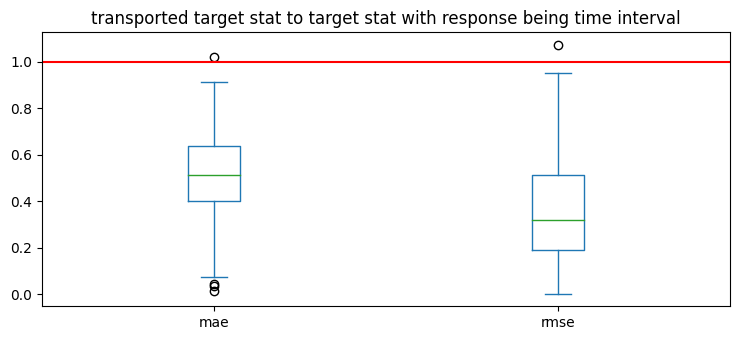

(0.5149940132146082, 0.3203022864604853)

In [5]:
score_path = os.path.join(output_dir, "exp5_poission_score.csv")

save_path = "../../outputs/mimic/exp5_poission_res.png"

box_plot_cts_short(score_path, "time interval", save_path=save_path)

In [14]:
""" 
Run multiple iterations using Linear regression
"""

score_path = os.path.join(output_dir, "exp5_linear_score.csv")
multi_proc_cts(score_path, n_components, cons_visits_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.LinearRegression, iteration=100)

iteration: 0


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 1


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 2
iteration: 3


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 4
iteration: 5


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 6


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 7
iteration: 8
iteration: 9


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 10


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 11
iteration: 12
iteration: 13
iteration: 14


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 15


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 16
iteration: 17
iteration: 18


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 19


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 20
iteration: 21
iteration: 22


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 23


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 24
iteration: 25


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 26


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 39
iteration: 40
iteration: 41
iteration: 42


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 43


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 44


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 45


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 46


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 47
iteration: 48
iteration: 49


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 50
iteration: 51


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 52
iteration: 53


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 54


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 55
iteration: 56
iteration: 57
iteration: 58


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 59


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 60
iteration: 61
iteration: 62
iteration: 63


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 69


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 70
iteration: 71
iteration: 72
iteration: 73
iteration: 74
iteration: 75
iteration: 76
iteration: 77
iteration: 78
iteration: 79
iteration: 80
iteration: 81
iteration: 82


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 83


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 84
iteration: 85
iteration: 86
iteration: 87


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 88
iteration: 89


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 90


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 91


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 92
iteration: 93
iteration: 94
iteration: 95
iteration: 96


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 97


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 98


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 99


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


array([[25063608.48100429, 37491138.02033283, 45230856.51219375,
        66696068.93041818, 41538359.36502391, 63064062.29317391],
       [25424971.98022331, 39670597.04232305, 42790467.70727548,
        60037784.13715401, 38984792.85350785, 57740211.44917104],
       [27894104.61128198, 41411567.58799347, 45625648.30868935,
        62950671.73739213, 41647585.054989  , 60508551.42035352],
       [29907897.45842775, 43758334.78648678, 37720976.15117052,
        49705485.99511475, 35966661.84533343, 46655222.46547013],
       [28159132.113075  , 42243595.83244244, 43174452.98100125,
        55644877.91154604, 38266748.484229  , 53180429.4691897 ],
       [27671001.33624268, 37800674.85852852, 50736447.4509057 ,
        63194783.62603384, 45640021.11512522, 59487382.87723941],
       [37752624.03668736, 54256552.18693066, 46941612.76854925,
        60643123.21513226, 45602734.90677162, 59102739.26440953],
       [26976968.88295706, 39997742.23649899, 35547389.33046269,
        49265034.1

enter this


<Figure size 640x480 with 0 Axes>

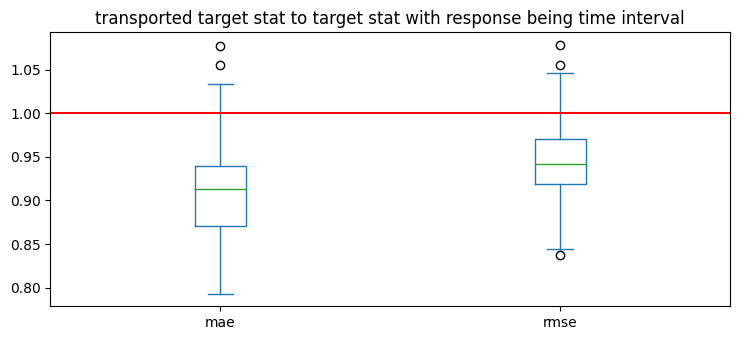

(0.9129872434396801, 0.9420167901701181)

In [4]:
score_path = os.path.join(output_dir, "exp5_linear_score.csv")
save_path = "../../outputs/mimic/exp5_linear_res.png"

box_plot_cts_short(score_path, "time interval", save_path=save_path)